In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

In [4]:
import insolver
from insolver.frame import InsolverDataFrame
from insolver.transforms import InsolverTransform
from insolver.transforms import (
    AutoFillNATransforms,
    OneHotEncoderTransforms,
    TransformMapValues,
    EncoderTransforms,
    DatetimeTransforms
)

# Load dataset

Let's load a dataset with the pd.read_csv() and create InsolverDataFrame.

In [4]:
#https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data
dataset = InsolverDataFrame(pd.read_csv("data/AB_NYC_2019.csv"))
dataset.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Information about a loaded dataset.

In [5]:
dataset.info()

<class 'insolver.frame.frame.InsolverDataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review          

Deleting useless columns.

In [6]:
dataset.drop(['id', 'name', 'host_id', 'host_name'], axis = 1, inplace=True)

In [7]:
dataset.info()

<class 'insolver.frame.frame.InsolverDataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   last_review                     38843 non-null  object 
 9   reviews_per_month               38843 non-null  float64
 10  calculated_host_listings_count  48895 non-null  int64  
 11  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(

In [8]:
dataset.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

# Tramsform dataset

Let's tranform all object columns and autofill null values. 

There are 4 object columns:
- `neighbourhood` consists of 221 unique values, for this column I use `EncoderTransforms` that encodes target labels with values between 0 and n_classes-1;
- `neighbourhood_group` consists of 5 unique values, for this column I use `OneHotEncoderTransforms` that encodes categorical features as a one-hot numeric array.
- `room_type` consists of 3 unique values, for this column I use `TransformMapValues` that transforms parameter values according to the given dictionary;
- `last_review` consists of date data, for this column I use `DatetimeTransforms` that preprocesses date and date time columns, it creates new column with the selected datetime feature, unix is used by default.

I use AutoFillNATransforms method to preprocess the NA values:
- For the `numerical_method` parameter I chose 'mean' value which use mean value  
- For the `categorical_method` I chose 'imputed_column' which fills with the frequent category and creates new bool column containing whether a value was imputed or not.

The second AutoFillNATransforms is used to fill the null values created after the OneHotEncoder Transform.

In [10]:
transformed = InsolverTransform(dataset, [
        AutoFillNATransforms(numerical_method = 'mean', categorical_method = 'imputed_column'),
        TransformMapValues('room_type', {'Entire home/apt' : 0, 'Private room' : 1, 'Shared room' : 1}),
        EncoderTransforms(['neighbourhood']),
        OneHotEncoderTransforms(['neighbourhood_group']),
        DatetimeTransforms(['last_review']),
        AutoFillNATransforms(),
        ])
transformed.ins_transform();

In [11]:
transformed.drop(['last_review'], axis=1, inplace=True)

In [12]:
transformed

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Imputed,neighbourhood_Imputed,room_type_Imputed,last_review_Imputed,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,last_review_unix
0,108,40.64749,-73.97237,1,149,1,9,0.210000,6,365,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1539907200
1,127,40.75362,-73.98377,0,225,1,45,0.380000,2,355,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1558396800
2,94,40.80902,-73.94190,1,150,3,0,1.373221,1,365,0,0,0,1,0.0,0.0,1.0,0.0,0.0,1561248000
3,41,40.68514,-73.95976,0,89,1,270,4.640000,1,194,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1562284800
4,61,40.79851,-73.94399,0,80,10,9,0.100000,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1542585600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,13,40.67853,-73.94995,1,70,2,0,1.373221,2,9,0,0,0,1,0.0,1.0,0.0,0.0,0.0,1561248000
48891,28,40.70184,-73.93317,1,40,4,0,1.373221,2,36,0,0,0,1,0.0,1.0,0.0,0.0,0.0,1561248000
48892,94,40.81475,-73.94867,0,115,10,0,1.373221,1,27,0,0,0,1,0.0,0.0,1.0,0.0,0.0,1561248000
48893,95,40.75751,-73.99112,1,55,1,0,1.373221,6,2,0,0,0,1,0.0,0.0,1.0,0.0,0.0,1561248000


# Feature Selection

For the feature selection I will use `FeatureSelection` class that allows you to compute features importances using selected method. 

Let's use two different selection methods: `random_forest`(used by default), `mutual_inf` and `lasso`.

## Models and plots

**Random Forest**

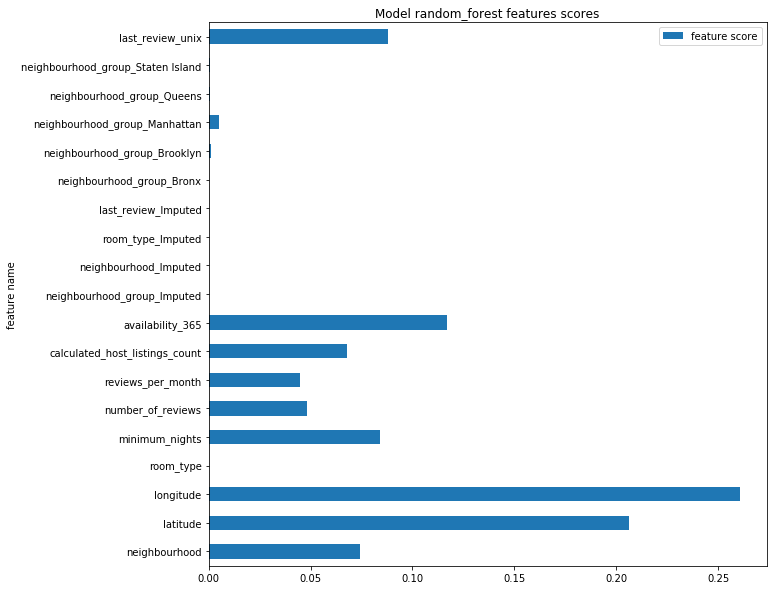

In [32]:
feature_selection = FeatureSelection(y_column='price', task='reg')
feature_selection.create_model(transformed)
feature_selection.plot_importance(figsize=(10,10))

Using method plot_importance you can see the most important features in created model. You can change plot size with the `figsize` parameter. It will create (5,5) plot by default.

**Mutual Information**

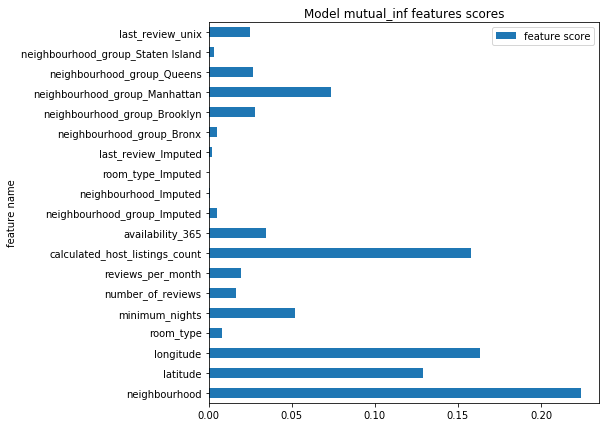

In [46]:
feature_selection = FeatureSelection(method='mutual_inf', y_column='price', task='reg')
feature_selection.create_model(transformed)
feature_selection.plot_importance(figsize=(7, 7))

**Lasso**

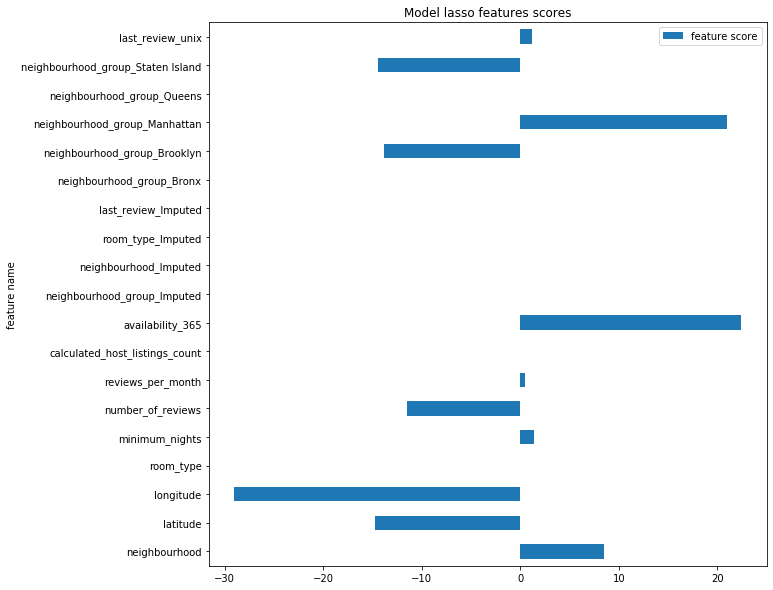

In [38]:
feature_selection = FeatureSelection(method='lasso', y_column='price', task='reg')
feature_selection.create_model(transformed)
feature_selection.plot_importance(figsize=(10,10))

## New dataset

You can create plot with the `importance_threshold` parameter and it will create plot only with the values bigger then `importance_threshold`.

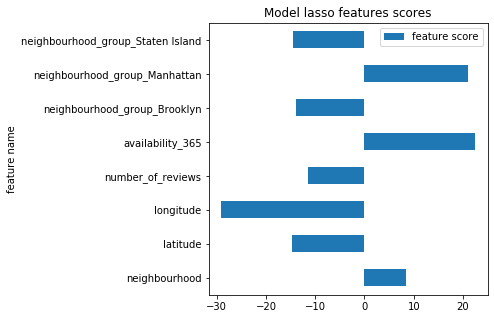

In [39]:
feature_selection.plot_importance(importance_threshold=3)

Let's create new dataset with the selected features only using `threshold = 3`.

In [42]:
new_dataset = feature_selection.create_new_dataset(threshold=3)
new_dataset

,neighbourhood,latitude,longitude,number_of_reviews,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Staten Island,price
0,108,40.64749,-73.97237,9,365,1.0,0.0,0.0,149
1,127,40.75362,-73.98377,45,355,0.0,1.0,0.0,225
2,94,40.80902,-73.94190,0,365,0.0,1.0,0.0,150
3,41,40.68514,-73.95976,270,194,1.0,0.0,0.0,89
4,61,40.79851,-73.94399,9,0,0.0,1.0,0.0,80
...,...,...,...,...,...,...,...,...,...
48890,13,40.67853,-73.94995,0,9,1.0,0.0,0.0,70
48891,28,40.70184,-73.93317,0,36,1.0,0.0,0.0,40
48892,94,40.81475,-73.94867,0,27,0.0,1.0,0.0,115
48893,95,40.75751,-73.99112,0,2,0.0,1.0,0.0,55


You can also create new dataset with the 'mean' (used by default) or 'median' `threshold`.

In [45]:
new_dataset_median = feature_selection.create_new_dataset(threshold='median')
new_dataset_median

,neighbourhood,minimum_nights,availability_365,neighbourhood_group_Manhattan,price
0,108,1,365,0.0,149
1,127,1,355,1.0,225
2,94,3,365,1.0,150
3,41,1,194,0.0,89
4,61,10,0,1.0,80
...,...,...,...,...,...
48890,13,2,9,0.0,70
48891,28,4,36,0.0,40
48892,94,10,27,1.0,115
48893,95,1,2,1.0,55


# Dimensionality Reduction

For the dimensionality reduction task I will use the `DimensionalityReduction` class. It has several different models that can be used for this task.

Matrix decomposition is represented by methods such as:
* `pca` - Principal Component Analysis, PCA;
* `svd` - truncated Singular Value Decomposition, SVD;
* `fa` - Factor Analysis, FA;
* `nmf` - Non-Negative Matrix Factorization, NMF. 

Discriminant Analysis is represented by methods such as:
* `lda` - Linear Discriminant Analysis, LDA.

Manifold learning is represented by methods such as:
* `lle` - Locally Linear Embedding, LLE;
* `isomap` - Isomap Embedding;
* `t_sne` - T-distributed Stochastic Neighbor Embedding, T-SNE.


Let's decompose this transformed dataset containing 20 columns using the PCA method.

In [16]:
new_dataset = DimensionalityReduction(method='pca').transform(X=transformed, n_components=10)
new_dataset 

,0,1,2,3,4,5,6,7,8,9
0,3.362869e+06,11.901710,-253.605888,-7.148001,-22.170715,-21.493989,-12.246664,-0.931738,0.769059,0.307488
1,-1.512673e+07,84.519733,-221.053152,-24.481916,12.032628,-18.993786,-9.761820,-1.583632,-0.722675,-0.428359
2,-1.797793e+07,9.627487,-230.921884,5.372608,-34.733556,-28.745311,-9.731255,0.095528,-0.679259,0.523109
3,-1.901473e+07,-65.001532,-78.749730,67.840818,233.596790,34.806700,5.953084,-0.917157,0.445035,-0.523183
4,6.844693e+05,-79.991686,107.036182,47.022149,-10.883226,-0.174703,5.712553,-1.039901,-0.882975,-0.429759
...,...,...,...,...,...,...,...,...,...,...
48890,-1.797793e+07,-92.965534,116.368154,93.258025,-24.828780,-2.562457,-2.229234,0.052157,0.546221,0.396200
48891,-1.797793e+07,-120.999952,88.070391,76.966127,-25.913251,-4.280991,-0.905671,0.062559,0.564634,0.379879
48892,-1.797793e+07,-45.408512,103.018507,12.770417,-22.978482,-4.863794,4.750554,0.112832,-0.804983,-0.366151
48893,-1.797793e+07,-106.749160,124.296085,11.148555,-23.102742,1.242234,-4.008324,0.091221,-0.696836,0.574723


Here is an example of how to plot created model using the y column. *(a random column was chosen as y)*

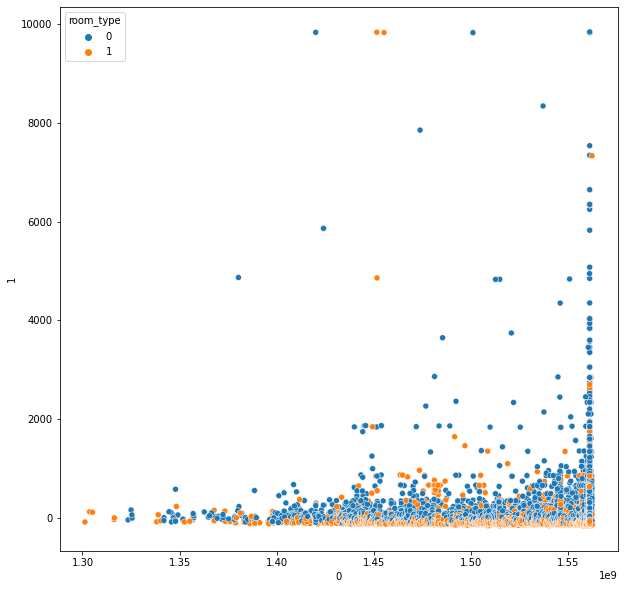

In [25]:
isomap = DimensionalityReduction(method='svd')
isomap.transform(X=transformed, n_components=2)
isomap.plot_transformed(y = transform['room_type'])

If `n_components` is greater than 3, `sns.pairplot` will be created. You can also change the plot settings. *(a random column was chosen as y)*

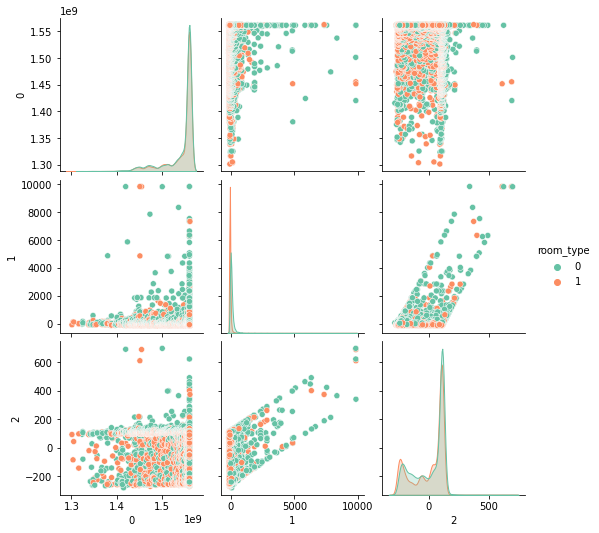

In [27]:
isomap = DimensionalityReduction(method='svd')
isomap.transform(X=transformed, n_components=3)
isomap.plot_transformed(y = transform['room_type'], figsize=(5,5), palette='Set2')

# Normalization

For the normalization reduction task I will use the `Normalization` class.

Normalization is represented by methods such as:
* `standard` - StandardScaler standardizes features by removing the mean and scaling to unit variance;
* `minmax` - MinMaxScaler transforms features by scaling each feature to a given range;
* `robust` - RobustScaler scales features using statistics that are robust to outliers;
* `normalizer` - Normalizer normalizes samples individually to unit norm;
* `yeo-johnson` - PowerTransformer(method=’yeo-johnson’) applies a power transform featurewise to make data more Gaussian-like, supports both positive or negative data;
* `box-cox` - PowerTransformer(method=’box-cox’) applies a power transform featurewise to make data more Gaussian-like, requires input data to be strictly positive;
* `log` - logarithm of the values.


Let's normalize transformed dataset using the `standard` method.

In [28]:
new_dataset = Normalization(method='standard').transform(transformed)
new_dataset

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Imputed,neighbourhood_Imputed,room_type_Imputed,last_review_Imputed,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,last_review_unix
0,0.012762,-1.493849,-0.437652,1.040134,-0.015493,-0.293996,-0.320414,-7.766410e-01,-0.034716,1.916250,0.0,0.0,0.0,-0.508710,-0.151071,1.196705,-0.891833,-0.362035,-0.087677,-0.101411
1,0.289156,0.452436,-0.684639,-0.961415,0.300974,-0.293996,0.487665,-6.631381e-01,-0.156104,1.840275,0.0,0.0,0.0,-0.508710,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,0.456164
2,-0.190897,1.468399,0.222497,1.040134,-0.011329,-0.196484,-0.522433,1.408386e-14,-0.186451,1.916250,0.0,0.0,0.0,1.965758,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,0.542145
3,-0.961892,-0.803398,-0.164450,-0.961415,-0.265335,-0.293996,5.538156,2.181110e+00,-0.186451,0.617065,0.0,0.0,0.0,-0.508710,-0.151071,1.196705,-0.891833,-0.362035,-0.087677,0.573411
4,-0.670950,1.275660,0.177216,-0.961415,-0.302811,0.144807,-0.320414,-8.500840e-01,-0.186451,-0.856865,0.0,0.0,0.0,-0.508710,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,-0.020641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,-1.369209,-0.924616,0.048089,1.040134,-0.344452,-0.245240,-0.522433,1.408386e-14,-0.156104,-0.788486,0.0,0.0,0.0,1.965758,-0.151071,1.196705,-0.891833,-0.362035,-0.087677,0.542145
48891,-1.151003,-0.497141,0.411637,1.040134,-0.469373,-0.147729,-0.522433,1.408386e-14,-0.156104,-0.583352,0.0,0.0,0.0,1.965758,-0.151071,1.196705,-0.891833,-0.362035,-0.087677,0.542145
48892,-0.190897,1.573480,0.075821,-0.961415,-0.157070,0.144807,-0.522433,1.408386e-14,-0.186451,-0.651730,0.0,0.0,0.0,1.965758,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,0.542145
48893,-0.176350,0.523774,-0.843881,1.040134,-0.406912,-0.293996,-0.522433,1.408386e-14,-0.034716,-0.841669,0.0,0.0,0.0,1.965758,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,0.542145


You can normalize only a selected list of column using the `column_names` parameter.

In [31]:
new_dataset = Normalization(method='standard', column_names=['price', 'reviews_per_month']).transform(transformed)
new_dataset

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Imputed,neighbourhood_Imputed,room_type_Imputed,last_review_Imputed,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,last_review_unix
0,108,40.64749,-73.97237,1,-0.015493,1,9,-7.766410e-01,6,365,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1539907200
1,127,40.75362,-73.98377,0,0.300974,1,45,-6.631381e-01,2,355,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1558396800
2,94,40.80902,-73.94190,1,-0.011329,3,0,1.408386e-14,1,365,0,0,0,1,0.0,0.0,1.0,0.0,0.0,1561248000
3,41,40.68514,-73.95976,0,-0.265335,1,270,2.181110e+00,1,194,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1562284800
4,61,40.79851,-73.94399,0,-0.302811,10,9,-8.500840e-01,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1542585600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,13,40.67853,-73.94995,1,-0.344452,2,0,1.408386e-14,2,9,0,0,0,1,0.0,1.0,0.0,0.0,0.0,1561248000
48891,28,40.70184,-73.93317,1,-0.469373,4,0,1.408386e-14,2,36,0,0,0,1,0.0,1.0,0.0,0.0,0.0,1561248000
48892,94,40.81475,-73.94867,0,-0.157070,10,0,1.408386e-14,1,27,0,0,0,1,0.0,0.0,1.0,0.0,0.0,1561248000
48893,95,40.75751,-73.99112,1,-0.406912,1,0,1.408386e-14,6,2,0,0,0,1,0.0,0.0,1.0,0.0,0.0,1561248000


If you want to transform some columns using the selected methods, use the `column_method` parameter and initialize the columns and methods as a dict.

In [37]:
new_dataset = Normalization(method='standard', 
                            column_method={'reviews_per_month':'minmax', 'price': 'robust'},).transform(transformed)
new_dataset

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Imputed,neighbourhood_Imputed,room_type_Imputed,last_review_Imputed,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,last_review_unix
0,0.012762,-1.493849,-0.437652,0.0,0.405660,-0.293996,-0.320414,0.003419,-0.034716,1.916250,0.0,0.0,0.0,0.0,-0.151071,1.196705,-0.891833,-0.362035,-0.087677,-0.101411
1,0.289156,0.452436,-0.684639,0.0,1.122642,-0.293996,0.487665,0.006326,-0.156104,1.840275,0.0,0.0,0.0,0.0,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,0.456164
2,-0.190897,1.468399,0.222497,0.0,0.415094,-0.196484,-0.522433,0.023307,-0.186451,1.916250,0.0,0.0,0.0,0.0,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,0.542145
3,-0.961892,-0.803398,-0.164450,0.0,-0.160377,-0.293996,5.538156,0.079159,-0.186451,0.617065,0.0,0.0,0.0,0.0,-0.151071,1.196705,-0.891833,-0.362035,-0.087677,0.573411
4,-0.670950,1.275660,0.177216,0.0,-0.245283,0.144807,-0.320414,0.001539,-0.186451,-0.856865,0.0,0.0,0.0,0.0,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,-0.020641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,-1.369209,-0.924616,0.048089,0.0,-0.339623,-0.245240,-0.522433,0.023307,-0.156104,-0.788486,0.0,0.0,0.0,0.0,-0.151071,1.196705,-0.891833,-0.362035,-0.087677,0.542145
48891,-1.151003,-0.497141,0.411637,0.0,-0.622642,-0.147729,-0.522433,0.023307,-0.156104,-0.583352,0.0,0.0,0.0,0.0,-0.151071,1.196705,-0.891833,-0.362035,-0.087677,0.542145
48892,-0.190897,1.573480,0.075821,0.0,0.084906,0.144807,-0.522433,0.023307,-0.186451,-0.651730,0.0,0.0,0.0,0.0,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,0.542145
48893,-0.176350,0.523774,-0.843881,0.0,-0.481132,-0.293996,-0.522433,0.023307,-0.034716,-0.841669,0.0,0.0,0.0,0.0,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,0.542145


Here is as example of the distribution plot created using the `plot_transformed` method.

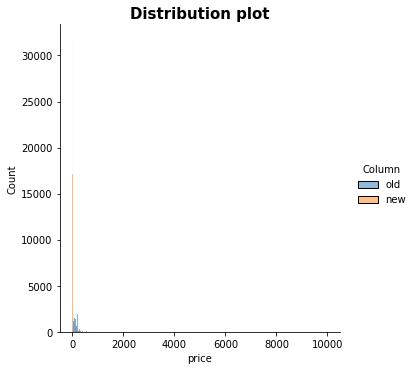

In [44]:
norm = Normalization(method='log', column_names='price')
new = norm.transform(transformed)
norm.plot_transformed(column = 'price')

# Sampling

For the sampling task I will use the `Sampling` class.

Sampling is represented by methods such as:
* `simple` sampling is a technique in which a subset is randomly selected number from a set;
* `systematic` sampling is a technique in which a subset is selected from a set using a defined step;
* `cluster` sampling is a technique in which a set is divided into clusters, then the set is determined by a randomly selected number of clusters;
* `stratified` sampling is a technique in which a set is divided into clusters, then the set is determined by a randomly selected number of units from each cluster.


Let's create a simple sampling with 1000 samples to keep.

In [13]:
new_dataset = Sampling(method='simple', n=1000).sample_dataset(transformed)
new_dataset 

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Imputed,neighbourhood_Imputed,room_type_Imputed,last_review_Imputed,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,last_review_unix
9026,74,40.64924,-73.96714,1,35,4,2,0.060000,1,157,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1471737600
27867,68,40.73688,-73.87644,1,55,15,0,1.373221,1,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,1561248000
1619,64,40.72320,-73.97927,1,75,26,57,0.700000,3,98,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1558310400
33634,13,40.69185,-73.95896,1,75,10,0,1.373221,1,17,0,0,0,1,0.0,1.0,0.0,0.0,0.0,1561248000
22508,60,40.65360,-73.92643,1,60,2,16,0.710000,1,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1510704000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40733,60,40.64842,-73.92753,0,45,2,17,2.980000,1,248,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1559865600
8481,54,40.77086,-73.89578,0,140,3,2,1.330000,2,363,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1560556800
23641,130,40.80563,-73.96362,0,130,7,23,0.950000,1,48,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1560384000
35164,77,40.73821,-73.81006,1,64,1,7,0.730000,5,90,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1560038400


Let's create a cluster sampling.

In [22]:
new_dataset = Sampling(method='cluster', n=2, n_clusters=5).sample_dataset(transformed)
new_dataset 

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,...,neighbourhood_Imputed,room_type_Imputed,last_review_Imputed,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,last_review_unix,cluster_id
39116,13,40.69468,-73.93304,0,450,1,10,1.840000,1,352,...,0,0,0,0.0,1.0,0.0,0.0,0.0,1561248000,5
39117,91,40.73378,-73.95569,1,199,1,0,1.373221,33,180,...,0,0,1,0.0,1.0,0.0,0.0,0.0,1561248000,5
39118,119,40.72165,-73.98693,1,110,1,0,1.373221,2,0,...,0,0,1,0.0,0.0,1.0,0.0,0.0,1561248000,5
39119,214,40.70755,-73.94892,0,90,30,2,0.450000,3,314,...,0,0,0,0.0,1.0,0.0,0.0,0.0,1554422400,5
39120,214,40.71025,-73.96921,0,550,7,0,1.373221,1,20,...,0,0,1,0.0,1.0,0.0,0.0,0.0,1561248000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9774,214,40.71477,-73.94761,1,70,5,5,0.110000,1,0,...,0,0,0,0.0,1.0,0.0,0.0,0.0,1468108800,1
9775,214,40.71733,-73.95566,0,150,6,0,1.373221,1,0,...,0,0,1,0.0,1.0,0.0,0.0,0.0,1561248000,1
9776,214,40.70884,-73.95742,1,80,1,3,0.060000,1,0,...,0,0,0,0.0,1.0,0.0,0.0,0.0,1440374400,1
9777,214,40.71704,-73.94509,1,60,1,0,1.373221,1,0,...,0,0,1,0.0,1.0,0.0,0.0,0.0,1561248000,1


Clusters can be created using the column specified in the `cluster_column` parameter.

In [15]:
new_dataset = Sampling(n = 1000, cluster_column = 'room_type', method='stratified').sample_dataset(transformed)
new_dataset 

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,...,neighbourhood_Imputed,room_type_Imputed,last_review_Imputed,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,last_review_unix,cluster_id
21835,201,40.76731,-73.95419,1,35,1,115,4.060000,2,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,1546300800,1
33813,13,40.69471,-73.93300,1,100,3,4,0.330000,7,109,...,0,0,0,0.0,1.0,0.0,0.0,0.0,1533859200,1
37795,95,40.75964,-73.99002,1,70,1,59,7.470000,6,314,...,0,0,0,0.0,0.0,1.0,0.0,0.0,1562198400,1
7098,158,40.68163,-73.96709,1,55,2,3,0.060000,1,189,...,0,0,0,0.0,1.0,0.0,0.0,0.0,1431820800,1
22360,94,40.81064,-73.94405,1,67,2,28,1.040000,2,132,...,0,0,0,0.0,0.0,1.0,0.0,0.0,1562112000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24521,94,40.82411,-73.95090,0,98,2,2,0.090000,1,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,1503360000,0
23478,61,40.79475,-73.94247,0,150,4,67,2.700000,3,242,...,0,0,0,0.0,0.0,1.0,0.0,0.0,1561852800,0
36753,28,40.68864,-73.91295,0,86,28,3,0.430000,1,66,...,0,0,0,0.0,1.0,0.0,0.0,0.0,1562025600,0
41825,31,40.67797,-73.99969,0,199,2,17,5.050000,1,31,...,0,0,0,0.0,1.0,0.0,0.0,0.0,1562112000,0


# Smoothing

For the smoothing task I will use the `Smoothing` class.

You can select the method by changing the `method` parameter:
* `moving_average` is a calculation to analyze data points by creating a series of averages of different subsets of the full data set, uses pandas.DataFrame.rolling().mean() method;
* `lowess` - Locally Weighted Scatterplot Smoothing is a generalization of moving average and polynomial regression, uses statsmodels.api.nonparametric.lowess;
* `s_g_filter` - Savitzky–Golay filter is achieved by fitting successive sub-sets of adjacent data points with a low-degree polynomial by the method of linear least squares, uses scipy.signal.savgol_filter;
* `fft` - Fast Fourier transform is an algorithm that computes the discrete Fourier transform (DFT) of a sequence, or its inverse (IDFT), uses scipy.fft.rfft and scipy.fft.irfft.


Let's smooth the `reviews_per_month` column and plot the result.

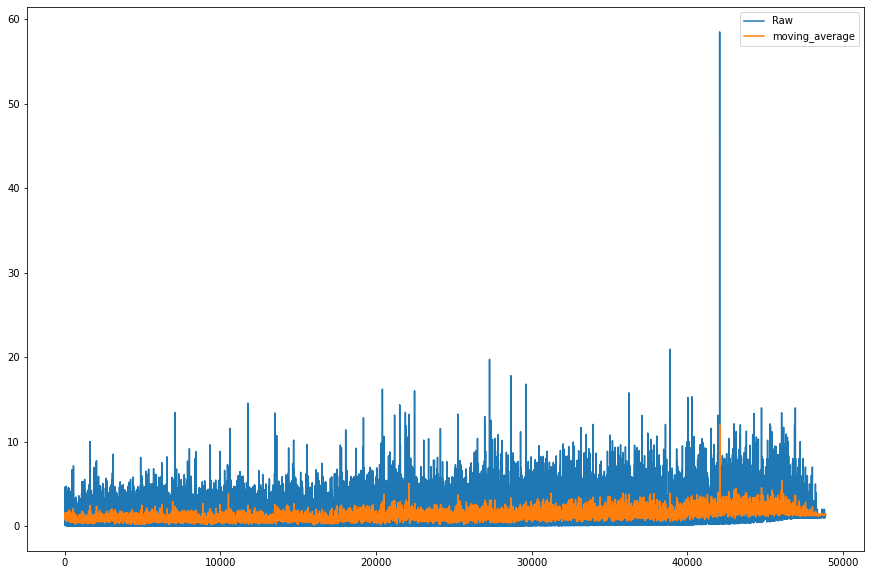

In [42]:
smoothing = Smoothing(method='moving_average', x_column='reviews_per_month')
smoothing.transform(data=transformed)
smoothing.plot_transformed()